## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
files = os.listdir()
data = [f for f in files if f.endswith(".csv")]

if data:
    df = pd.read_csv(data[0])
else:
    print("No data files found in the directory.")

df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [5]:
from sklearn.preprocessing import LabelEncoder

#Words to numbers
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = le.fit_transform(df[column])

In [7]:
#Standardize data, helpful for linear regression and Neural Networks

copy_df = df.copy()

for column in copy_df.columns:
    copy_df[column] = copy_df[column]/copy_df[column].abs().max()
copy_df

,date,precipitation,temp_max,temp_min,wind,weather
0,0.000000,0.000000,0.359551,0.273224,0.494737,0.00
1,0.000685,0.194991,0.297753,0.153005,0.473684,0.50
2,0.001370,0.014311,0.328652,0.393443,0.242105,0.50
3,0.002055,0.363148,0.342697,0.306011,0.494737,0.50
4,0.002740,0.023256,0.250000,0.153005,0.642105,0.50
...,...,...,...,...,...,...
1456,0.997260,0.153846,0.123596,0.092896,0.305263,0.50
1457,0.997945,0.026834,0.140449,0.092896,0.136842,0.50
1458,0.998630,0.000000,0.202247,0.032787,0.273684,0.25
1459,0.999315,0.000000,0.157303,-0.054645,0.357895,1.00


In [11]:
def drop():
    global X
    global y
    
    X = copy_df.drop(columns=["weather"])
    y = copy_df["weather"]

drop()
copy_df

,date,precipitation,temp_max,temp_min,wind,weather
0,0.000000,0.000000,0.359551,0.273224,0.494737,0.00
1,0.000685,0.194991,0.297753,0.153005,0.473684,0.50
2,0.001370,0.014311,0.328652,0.393443,0.242105,0.50
3,0.002055,0.363148,0.342697,0.306011,0.494737,0.50
4,0.002740,0.023256,0.250000,0.153005,0.642105,0.50
...,...,...,...,...,...,...
1456,0.997260,0.153846,0.123596,0.092896,0.305263,0.50
1457,0.997945,0.026834,0.140449,0.092896,0.136842,0.50
1458,0.998630,0.000000,0.202247,0.032787,0.273684,0.25
1459,0.999315,0.000000,0.157303,-0.054645,0.357895,1.00


## Data Clean Up ##

In [13]:
stats.zscore(copy_df) #Find outliers

,date,precipitation,temp_max,temp_min,wind,weather
0,-1.730866,-0.453650,-0.495299,-0.644212,1.014980,-2.310905
1,-1.728495,1.178598,-0.794731,-1.082347,0.875833,-0.631605
2,-1.726124,-0.333852,-0.645015,-0.206077,-0.654780,-0.631605
3,-1.723753,2.586224,-0.576962,-0.524720,1.014980,-0.631605
4,-1.721381,-0.258978,-1.026111,-1.082347,1.989006,-0.631605
...,...,...,...,...,...,...
1456,1.721381,0.834179,-1.638585,-1.301414,-0.237340,-0.631605
1457,1.723753,-0.229029,-1.556922,-1.301414,-1.350513,-0.631605
1458,1.726124,-0.453650,-1.257490,-1.520481,-0.446060,-1.471255
1459,1.728495,-0.453650,-1.475259,-1.839125,0.110527,1.047695


In [15]:
#Drop outliers
z = np.abs(stats.zscore(copy_df))
threshold_z = 3
outliers = np.where(z > threshold_z)[0]
copy_df = copy_df.drop(outliers)
drop()
copy_df.shape

(1410, 6)

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

         feature        VIF
0           date   3.523786
1  precipitation   1.515541
2       temp_max  21.455182
3       temp_min  15.821641
4           wind   4.468748


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

copy_df = copy_df.copy()

copy_df["pca"] = pca.fit_transform(copy_df[["temp_max", "temp_min"]])

copy_df = copy_df.drop(["temp_max", "temp_min"], axis=1)
drop()
copy_df

,date,precipitation,wind,weather,pca
0,0.000000,0.000000,0.494737,0.00,0.207683
1,0.000685,0.194991,0.473684,0.50,0.341286
2,0.001370,0.014311,0.242105,0.50,0.128491
3,0.002055,0.363148,0.494737,0.50,0.191032
4,0.002740,0.023256,0.642105,0.50,0.369316
...,...,...,...,...,...
1456,0.997260,0.153846,0.305263,0.50,0.492177
1457,0.997945,0.026834,0.136842,0.50,0.482284
1458,0.998630,0.000000,0.273684,0.25,0.494675
1459,0.999315,0.000000,0.357895,1.00,0.591841


In [21]:
copy_df.isna().sum()

date             0
precipitation    0
wind             0
weather          0
pca              0
dtype: int64

In [ ]:
copy_df = copy_df.dropna() #drop rows with missing values

In [23]:
copy_df.duplicated().sum()

0

In [ ]:
copy_df = copy_df.drop_duplicates() #drop duplicate rows

In [25]:
drop()
copy_df

,date,precipitation,wind,weather,pca
0,0.000000,0.000000,0.494737,0.00,0.207683
1,0.000685,0.194991,0.473684,0.50,0.341286
2,0.001370,0.014311,0.242105,0.50,0.128491
3,0.002055,0.363148,0.494737,0.50,0.191032
4,0.002740,0.023256,0.642105,0.50,0.369316
...,...,...,...,...,...
1456,0.997260,0.153846,0.305263,0.50,0.492177
1457,0.997945,0.026834,0.136842,0.50,0.482284
1458,0.998630,0.000000,0.273684,0.25,0.494675
1459,0.999315,0.000000,0.357895,1.00,0.591841


## Statistical Modeling ##

In [27]:
copy_df.describe()

,date,precipitation,wind,weather,pca
count,1410.000000,1410.000000,1410.000000,1410.000000,1.410000e+03
mean,0.498257,0.039626,0.332087,0.693617,-1.763759e-17
std,0.288009,0.079055,0.140800,0.300836,3.353881e-01
min,0.000000,0.000000,0.042105,0.000000,-7.368607e-01
25%,0.249486,0.000000,0.231579,0.500000,-2.757307e-01
50%,0.498288,0.000000,0.305263,0.500000,7.278186e-03
75%,0.747774,0.035778,0.410526,1.000000,2.513518e-01
max,1.000000,0.404293,0.789474,1.000000,9.317590e-01


In [29]:
copy_df.corr()

,date,precipitation,wind,weather,pca
date,1.000000,-0.040127,-0.050085,0.072124,-0.163875
precipitation,-0.040127,1.000000,0.302022,-0.296341,0.174847
wind,-0.050085,0.302022,1.000000,-0.039846,0.088187
weather,0.072124,-0.296341,-0.039846,1.000000,-0.223205
pca,-0.163875,0.174847,0.088187,-0.223205,1.000000


In [31]:
kstest(X, "norm").pvalue #p-value for each row

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.46988725e-84])

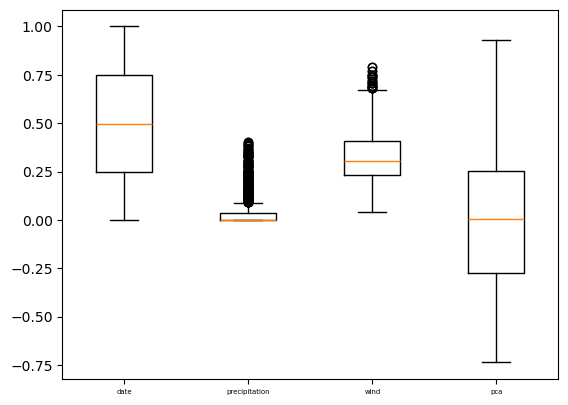

In [33]:
import seaborn as sn

#When dealing with very large data-sets/working with others using graphs to see things would be beneficial to everyone's sanity
fig, ax = plt.subplots()
ax.boxplot(X)
ax.set_xticklabels(X.columns, size=5)
plt.show()

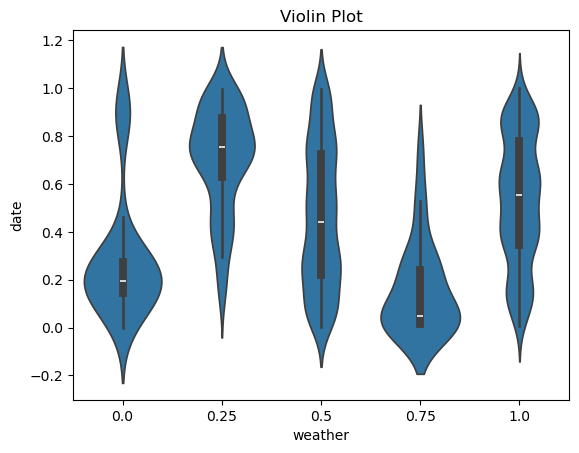

In [41]:
sn.violinplot(x="weather", y="date", data=copy_df)
plt.title("Violin Plot")
plt.show()

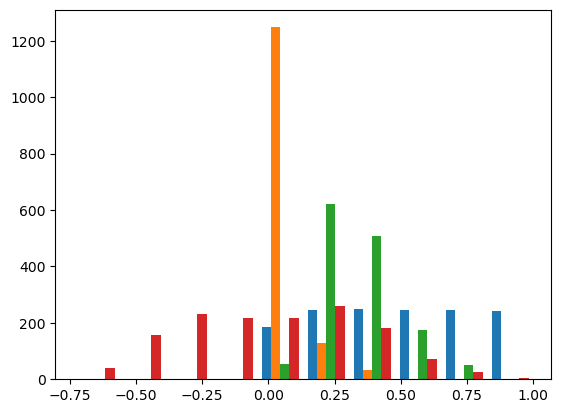

In [43]:
plt.hist(X)
plt.show()

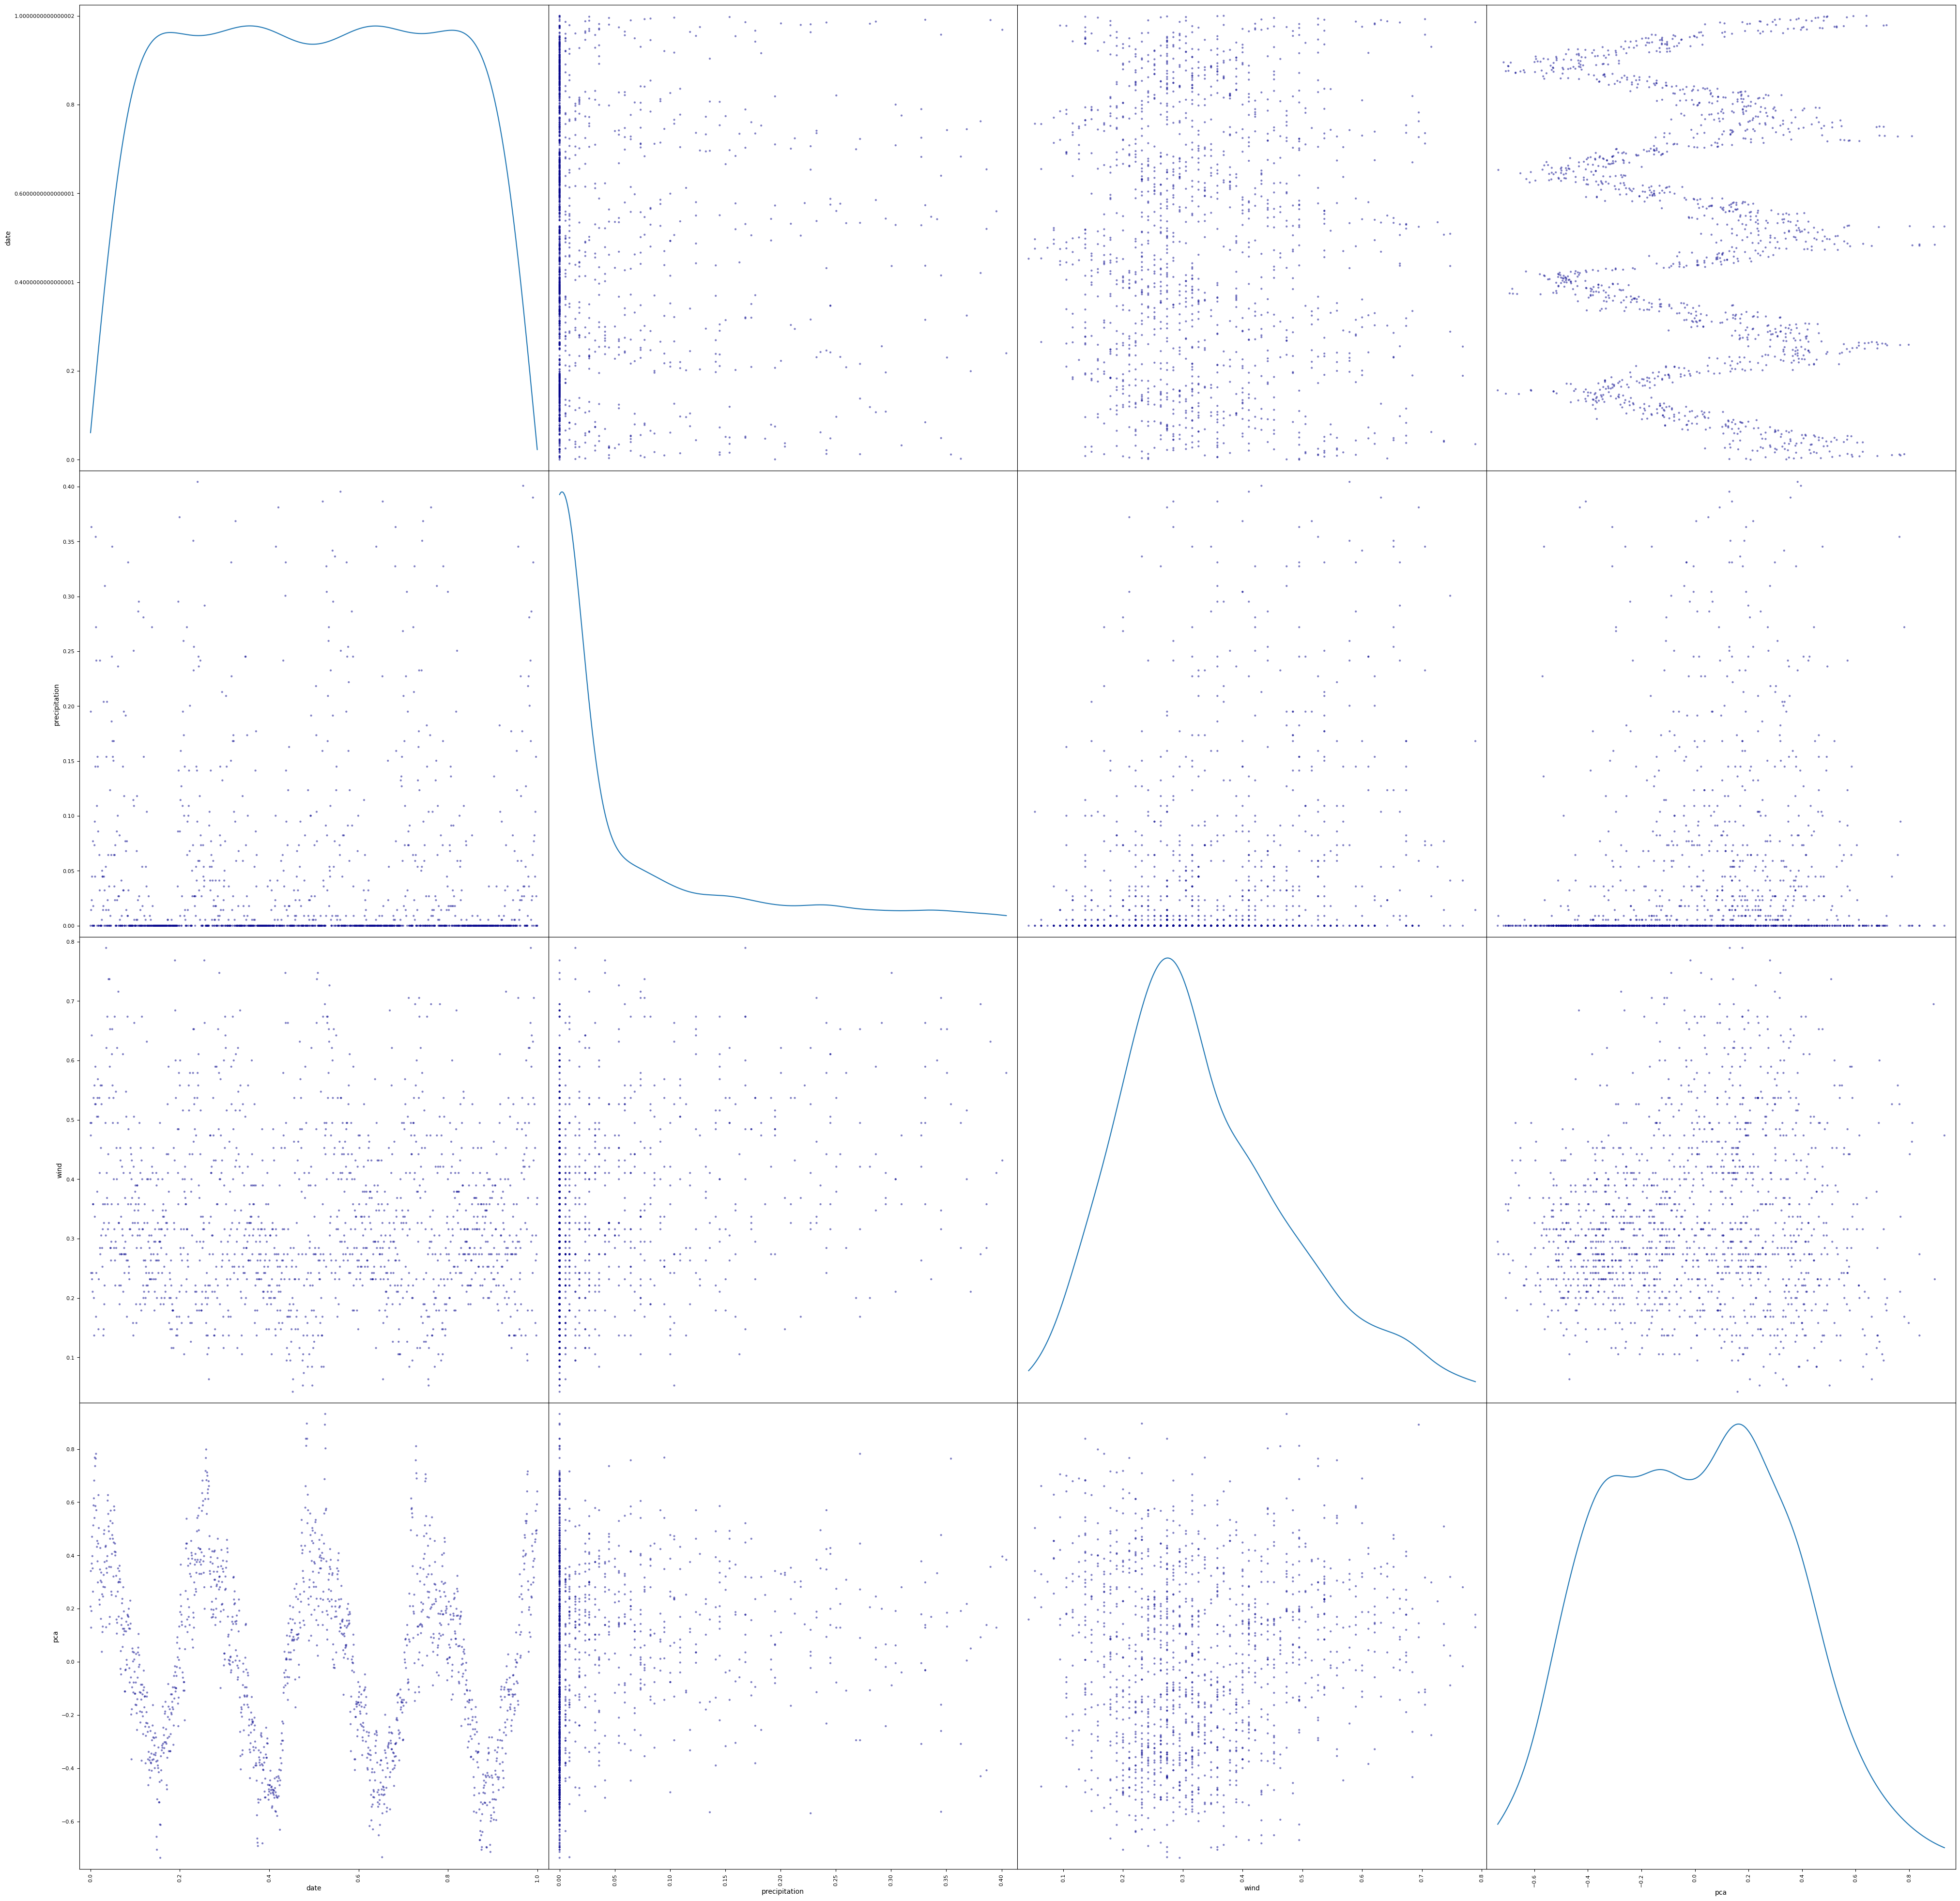

In [45]:
from pandas.plotting import scatter_matrix

scatter_matrix(X, alpha = 0.5, figsize = (50, 50), diagonal = "kde", c="#00008B");

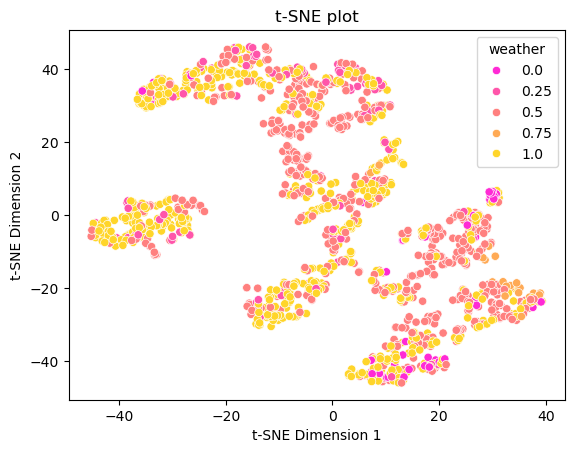

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_embedded = tsne.fit_transform(X)

sn.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette=sn.color_palette("spring", 5))
plt.title("t-SNE plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

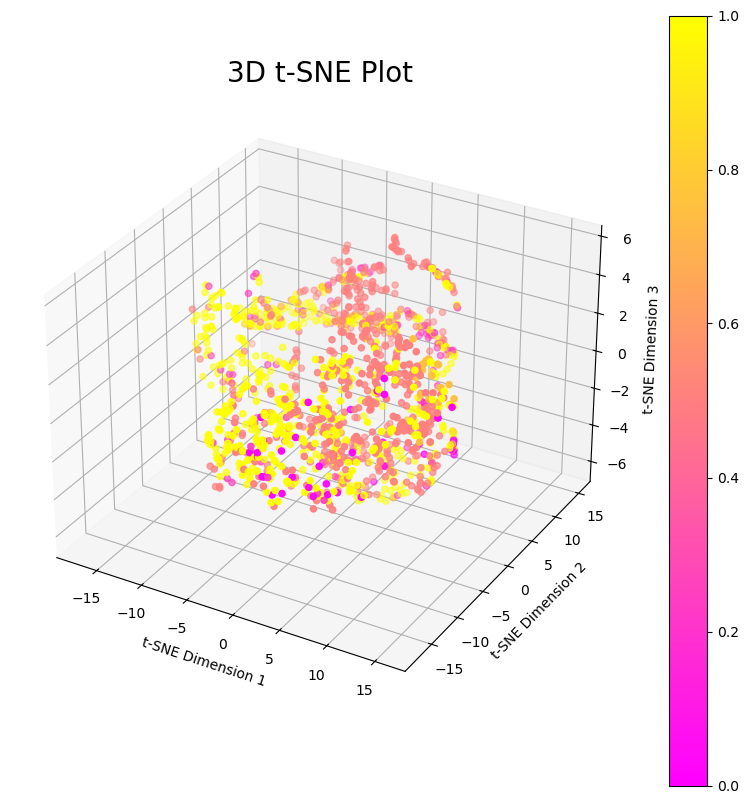

In [184]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="spring")

ax.set_title("3D t-SNE Plot", fontsize=20)
ax.set_xlabel("t-SNE Dimension 1", fontsize=10)
ax.set_ylabel("t-SNE Dimension 2", fontsize=10)
ax.set_zlabel("t-SNE Dimension 3", fontsize=10)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=10)

plt.show()

## Training Model ##

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [70]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [72]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(987, 4)
(212, 4)
(211, 4)


In [74]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype = torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [76]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [162]:
train_dataloader = DataLoader(training_data, batch_size = 2, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 2, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 2, shuffle = True)

In [164]:
Hidden_Neurons = 30

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], Hidden_Neurons)
        
        self.hidden_layer1 = nn.Linear(X.shape[1], Hidden_Neurons)
        self.hidden_layer2 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer3 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer4 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        
        self.linear = nn.Linear(Hidden_Neurons, 1) #output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #Forward Propagation
        x = x.to(device)
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [166]:
summary(model, (X.shape[1],), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1]                       2,940
├─Linear: 1-1                            [30]                      150
├─Linear: 1-2                            [1]                       31
├─Sigmoid: 1-3                           [1]                       --
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [168]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-4)

In [170]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        #Back Propagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
        
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1 
    Training Loss: 0.3246 
    Training Accuracy: 43.6677 
    Validation Loss: 0.0685 
    Validation Accuracy: 43.3962
Epoch no. 2 
    Training Loss: 0.3112 
    Training Accuracy: 45.4914 
    Validation Loss: 0.0673 
    Validation Accuracy: 43.3962
Epoch no. 3 
    Training Loss: 0.3062 
    Training Accuracy: 45.4914 
    Validation Loss: 0.0667 
    Validation Accuracy: 43.3962
Epoch no. 4 
    Training Loss: 0.3034 
    Training Accuracy: 45.4914 
    Validation Loss: 0.0663 
    Validation Accuracy: 43.3962
Epoch no. 5 
    Training Loss: 0.3018 
    Training Accuracy: 45.4914 
    Validation Loss: 0.066 
    Validation Accuracy: 43.3962
Epoch no. 6 
    Training Loss: 0.3005 
    Training Accuracy: 45.4914 
    Validation Loss: 0.0657 
    Validation Accuracy: 43.3962
Epoch no. 7 
    Training Loss: 0.2992 
    Training Accuracy: 45.4914 
    Validation Loss: 0.0655 
    Validation Accuracy: 43.3962
Epoch no. 8 
    Training Loss: 0.2984 
    Training Accuracy: 

In [172]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in testing_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()
        
        total_acc_test += acc
        total_loss_test += batch_loss_test

print(f'''Accuracy Score: {round(total_acc_test/testing_data.__len__()*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 50.237 
Loss: 0.1195


## Post-Training Analysis ##

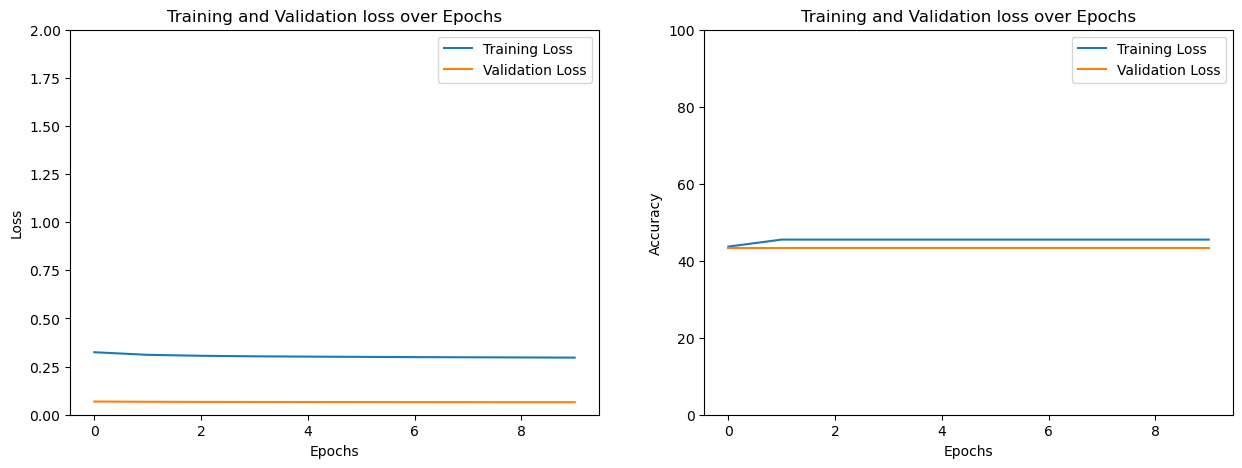

In [174]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [176]:
torch.save(model.state_dict(), "Seattle.pth")

In [178]:
loaded_model = MyModel().to(device)
loaded_model.load_state_dict(torch.load("Seattle.pth"))
loaded_model.eval()

MyModel(
  (input_layer): Linear(in_features=4, out_features=30, bias=True)
  (hidden_layer1): Linear(in_features=4, out_features=30, bias=True)
  (hidden_layer2): Linear(in_features=30, out_features=30, bias=True)
  (hidden_layer3): Linear(in_features=30, out_features=30, bias=True)
  (hidden_layer4): Linear(in_features=30, out_features=30, bias=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)